# Packages

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import math #has math.ceil
import geopandas as gpd
import regionmask
import rasterio.features
import rasterio
from rasterio.features import geometry_mask
from scipy.stats import linregress

# Read Data

In [3]:
data = xr.open_dataset("/g/data/k10/pg1235/abby_smyth_project/MONTHLYprecip1910_2019_file3.nc")  # path for your nc data

# Figure 1: WA Timeseries

### BOM data (not NCI, as above)

In [34]:
data_spreadsheet = pd.read_csv("/g/data/k10/mf9479/Data_analysis_unit/wa_rain_anom.csv")
Year = data_spreadsheet['year']
Precipitation = data_spreadsheet['precip']

years = list(range(1900,2025))

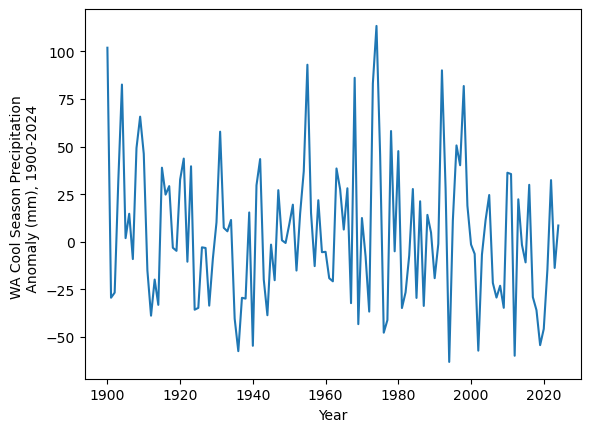

In [36]:
# plot that data 
plt.plot(years, Precipitation)
plt.xlabel('Year')
plt.ylabel('WA Cool Season Precipitation \n Anomaly (mm), 1900-2024   ')

plt.savefig('histogram_WA.png',dpi = 300)

# Masking the Shapefile

### Clip Cool Season Data

In [4]:
# Select cool-season months (April to October)
data_cool = data.where(data["time"].dt.month.isin([4, 5, 6, 7, 8, 9, 10]), drop=True)

# Sum rainfall over cool-season per year
data_seasonal = data_cool.groupby("time.year").sum(dim="time")

### Shapefile

<Axes: >

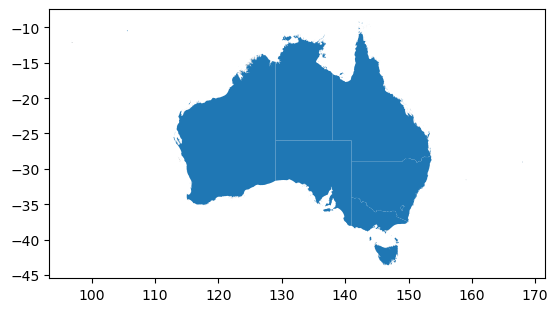

In [5]:
gdf = gpd.read_file('/g/data/k10/pg1235/project1/STE_2021_AUST_GDA2020.shp') #path to shapefile
gdf.plot()

In [6]:
gdf

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,6,Tasmania,0,No change,AUS,Australia,6.801754e+04,http://linked.data.gov.au/dataset/asgsed3/STE/6,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,7,Northern Territory,0,No change,AUS,Australia,1.348134e+06,http://linked.data.gov.au/dataset/asgsed3/STE/7,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,8,Australian Capital Territory,0,No change,AUS,Australia,2.358133e+03,http://linked.data.gov.au/dataset/asgsed3/STE/8,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1..."
8,9,Other Territories,0,No change,AUS,Australia,2.557420e+02,http://linked.data.gov.au/dataset/asgsed3/STE/9,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."
9,Z,Outside Australia,1,New,ZZZ,Outside Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/STE/Z,None


In [7]:
gdf=gdf.iloc[[4]] # choose 4 here - WA is at the row index 4

In [8]:
getbounds=gdf.bounds;getbounds

,minx,miny,maxx,maxy
4,112.921125,-35.191995,129.001928,-13.68869


In [9]:
lat_min = getbounds.iloc[0,3]  # Minimum latitude
lat_max = getbounds.iloc[0,1]  # Maximum latitude
lon_min = getbounds.iloc[0,0]  # Minimum longitude
lon_max = getbounds.iloc[0,2]  # Maximum longitude
ds = data_seasonal.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

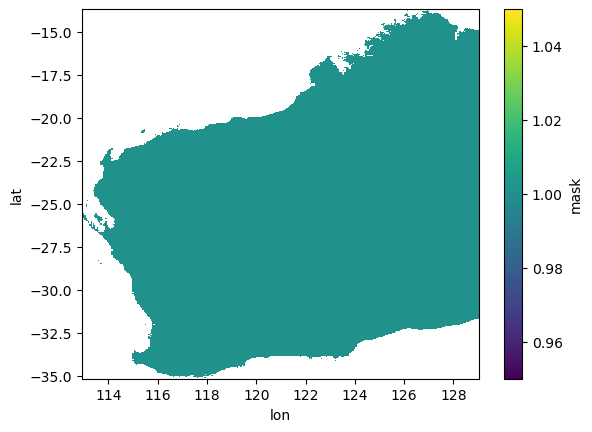

In [10]:
# Assume shapefile is in the same coordinate system as the gridded data (it is)
# Create a mask of the polygon for the lat and lon values in ds
da_mask_zeros = regionmask.mask_geopandas(geodataframe = gdf, lon_or_obj = ds.lon.values, lat = ds.lat.values)

# setting the points inside the region to 1, to mask it
da_mask = xr.where(da_mask_zeros == 4, 1, np.nan) # WA values were initally 4 (in gdf)
da_mask.plot()

In [11]:
da_mask

<xarray.DataArray 'mask' (lat: 430, lon: 322)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 2kB -13.7 -13.75 -13.8 -13.85 ... -35.05 -35.1 -35.15
  * lon      (lon) float32 1kB 112.9 113.0 113.1 113.1 ... 128.9 128.9 129.0

In [12]:
%%time
ds_state = ds.where(da_mask==1) # execute the mask

CPU times: user 187 ms, sys: 84.5 ms, total: 272 ms
Wall time: 269 ms


In [13]:
ds_state # clipped data set !

<xarray.Dataset> Size: 305MB
Dimensions:   (year: 110, lon: 322, bnds: 2, lat: 430)
Coordinates:
  * lon       (lon) float32 1kB 112.9 113.0 113.1 113.1 ... 128.9 128.9 129.0
  * lat       (lat) float32 2kB -13.7 -13.75 -13.8 ... -35.05 -35.1 -35.15
  * year      (year) int64 880B 1910 1911 1912 1913 1914 ... 2016 2017 2018 2019
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (year, lon, bnds, lat) float32 122MB nan nan nan ... nan nan nan
    lat_bnds  (year, lat, bnds, lon) float32 122MB nan nan nan ... nan nan nan
    precip    (year, lat, lon) float32 61MB nan nan nan nan ... nan nan nan nan
Attributes: (12/35)
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6, ACDD-1.3
    source:                    Data is from site-based observation data recor...
    institution:               Australian Bureau of Meteorology, GPO Box 1289...
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    ...                        ...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 05:42:26
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:                   Fri Jan 24 11:04:07 2025: cdo invertlat /g/dat...
    CDO:                       Climate Data Operators version 2.4.0 (https://...

# Figure 2: 1910 vs 2019 Rainfall Map

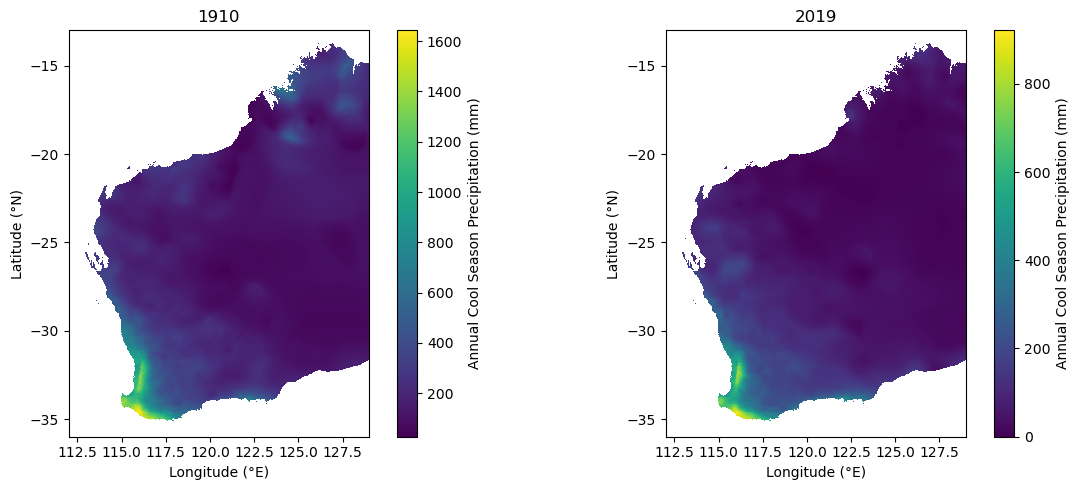

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Create 1 row, 2 columns

# First subplot - 1910
data_1910 = ds_state['precip'].isel(year=0)
plot1 = data_1910.plot(ax=axes[0], cbar_kwargs={"label": "Annual Cool Season Precipitation (mm)"})
axes[0].set_title("1910")
axes[0].set_xlim(112, 129)
axes[0].set_ylim(-36, -13)
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")
axes[0].set_aspect('equal')

# Second subplot - 2019
data_2019 = ds_state['precip'].isel(year=109)
plot2 = data_2019.plot(ax=axes[1], cbar_kwargs={"label": "Annual Cool Season Precipitation (mm)"})
axes[1].set_title("2019")
axes[1].set_xlim(112, 129)
axes[1].set_ylim(-36, -13)
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")
axes[1].set_aspect('equal')

plt.tight_layout()  # Avoids overlap
plt.savefig("Fig2", dpi = 300)
plt.show()

# Figure 3: Trend Map

In [24]:
regression = ds_state.polyfit(dim="year", deg=1) # applies regression function to WA data

In [25]:
regression

<xarray.Dataset> Size: 11MB
Dimensions:                        (lon: 322, bnds: 2, lat: 430, degree: 2)
Coordinates:
  * lon                            (lon) float32 1kB 112.9 113.0 ... 128.9 129.0
  * bnds                           (bnds) int64 16B 0 1
  * lat                            (lat) float32 2kB -13.7 -13.75 ... -35.15
  * degree                         (degree) int64 16B 1 0
Data variables:
    lon_bnds_polyfit_coefficients  (degree, lon, bnds, lat) float64 4MB nan ....
    lat_bnds_polyfit_coefficients  (degree, lat, bnds, lon) float64 4MB nan ....
    precip_polyfit_coefficients    (degree, lat, lon) float64 2MB nan ... nan
Attributes: (12/35)
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6, ACDD-1.3
    source:                    Data is from site-based observation data recor...
    institution:               Australian Bureau of Meteorology, GPO Box 1289...
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    ...                        ...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 05:42:26
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:                   Fri Jan 24 11:04:07 2025: cdo invertlat /g/dat...
    CDO:                       Climate Data Operators version 2.4.0 (https://...

In [26]:
seasonal_s = regression.precip_polyfit_coefficients.sel(degree = 1) # selects the coefficient (gradient)

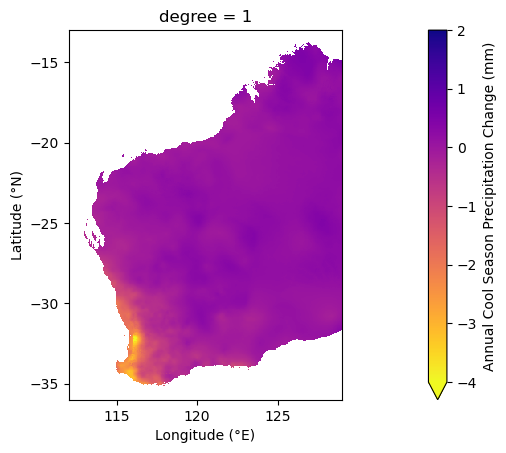

In [31]:
seasonal_s.plot(vmin=-4, vmax=2, cmap="plasma_r", cbar_kwargs={"label": "Annual Cool Season Precipitation Change (mm)"}) 

plt.axis('square')
plt.xlim(112,129)
plt.ylim(-36,-13)
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")

plt.savefig("final_WA", dpi = 300)